In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pingouin as pg
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import expit
from statannotations.Annotator import Annotator

from itertools import combinations

%matplotlib widget
sns.set_palette("pastel")
palette = sns.color_palette("pastel")

<h1 style="text-align:center">Dataset Loading</h1>

In [2]:
data = pd.read_excel("data/Telomere MDD.xlsx")

In [3]:
data.info(verbose=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   telomere_length                64 non-null     float64
 1   age                            64 non-null     int64  
 2   sex                            64 non-null     int64  
 3   civil_status                   64 non-null     int64  
 4   educ_level                     64 non-null     int64  
 5   employ_stat                    64 non-null     int64  
 6   ses                            64 non-null     int64  
 7   average_sleep                  64 non-null     int64  
 8   smoking_daily_ave              64 non-null     int64  
 9   alcohol_daily_ave              64 non-null     int64  
 10  prohibited_drug                64 non-null     int64  
 11  prohibited_drug_type           64 non-null     int64  
 12  fruit_veg                      64 non-null     int64

<h1 style="text-align:center">Participant Distribution</h1>

In [4]:
sex_labels = data.sex.map({1: "Male", 2: "Female"})

<h2>Age Distribution by Sex</h2>

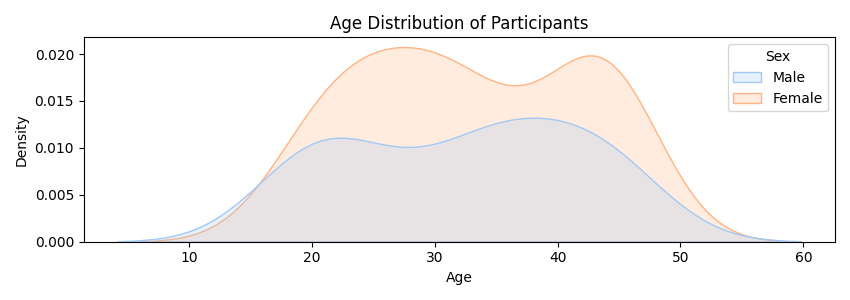

In [5]:
age_distribution_fig, age_distribution_axis = plt.subplots(1, 1, figsize=(8.5, 3))

sns.kdeplot(
    data=data,
    x="age",
    hue=sex_labels,
    ax=age_distribution_axis,
    common_norm=True,
    palette="pastel",
    fill=True,
)

age_distribution_axis.set(
    title="Age Distribution of Participants", xlabel="Age", ylabel="Density"
)

age_distribution_axis.get_legend().set_title("Sex")

age_distribution_fig.tight_layout()
age_distribution_fig.savefig("figures/Age Distribution.png", dpi=300)

<h2>Telomere Variation by Age</h2>

In [6]:
a_tl_linreg = stats.linregress(x=data.age, y=data.telomere_length)

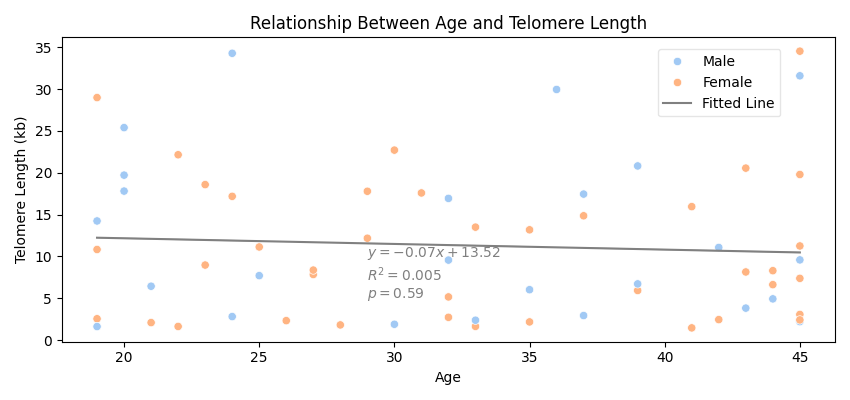

In [7]:
age_vs_tl_fig, age_vs_tl_axis = plt.subplots(1, 1, figsize=(8.5, 4))
age_vs_tl_axis.set(
    title="Relationship Between Age and Telomere Length",
    xlabel="Age",
    ylabel="Telomere Length (kb)",
)

sns.scatterplot(x=data.age, y=data.telomere_length, hue=sex_labels, ax=age_vs_tl_axis)

sns.lineplot(
    x=data.age,
    y=(a_tl_linreg.slope * data.age + a_tl_linreg.intercept),
    label="Fitted Line",
    ax=age_vs_tl_axis,
    color="gray",
)

age_vs_tl_axis.text(
    x=29,
    y=5,
    s=f"$y={a_tl_linreg.slope:.2f}x+{a_tl_linreg.intercept:.2f}$"
    f"\n$R^{2} = {a_tl_linreg.rvalue**2:.3f}$"
    f"\n$p = {a_tl_linreg.pvalue:.2f}$",
    alpha=0.5,
)


age_vs_tl_axis.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0)
age_vs_tl_axis.legend(loc="center", bbox_to_anchor=(0.85, 0.85), framealpha=0.5)

age_vs_tl_fig.tight_layout()
age_vs_tl_fig.savefig(
    "figures/Age vs. Telomere Length (Linear Regression).png", dpi=300
)

<h1 style="text-align:center">Telomere Length Variation By Sex</h1>

<h2>Test for Normality (Shapiro-Wilk Test)</h2>

In [8]:
sex_tl_temp = data[["sex", "telomere_length"]].copy()
sex_tl_temp["sex"] = sex_labels
pg.normality(data=sex_tl_temp, dv="telomere_length", group="sex", method="shapiro")

,W,pval,normal
sex,,,
Male,0.884849,0.008714,False
Female,0.906191,0.003336,False


<h2>Test for Homoscedasticity (Levene's Test)</h2>

In [9]:
pg.homoscedasticity(
    data=sex_tl_temp, dv="telomere_length", group="sex", method="levene"
)

,W,pval,equal_var
levene,0.877211,0.352601,True


<h2>Group Comparison (Mann-Whitney Test) & Visualization</h2>

In [10]:
sex_tl_comp = stats.mannwhitneyu(
    x=data.loc[data.sex == 1, "telomere_length"],
    y=data.loc[data.sex == 2, "telomere_length"],
)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Male vs. Female: Mann-Whitney-Wilcoxon test two-sided, P_val:6.203e-01 U_stat=5.240e+02


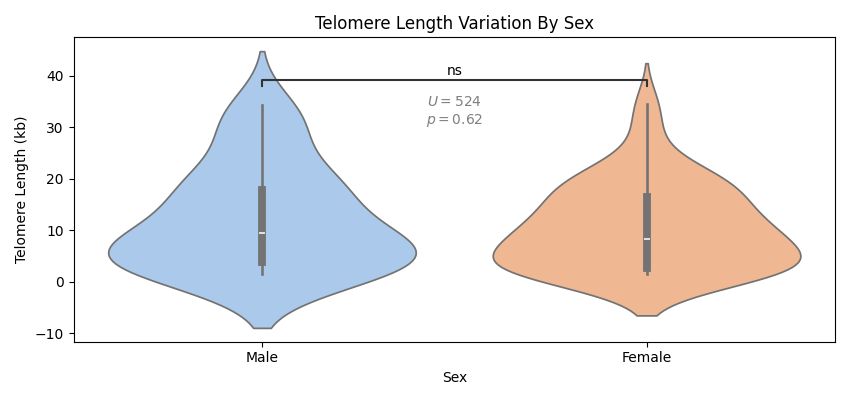

In [11]:
sex_tl_fig, sex_tl_axis = plt.subplots(1, 1, figsize=(8.5, 4))
sex_tl_axis.set(
    title="Telomere Length Variation By Sex",
    xlabel="Sex",
    ylabel="Telomere Length (kb)",
)

sns.violinplot(x=sex_labels, y=data.telomere_length, hue=sex_labels, fill=True)


annotator = Annotator(
    ax=sex_tl_axis, pairs=[("Male", "Female")], x=sex_labels, y=data.telomere_length
)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()

sex_tl_axis.text(
    0.5,
    33,
    f"$U = {sex_tl_comp.statistic:.0f}$" f"\n$p = {sex_tl_comp.pvalue:.2f}$",
    alpha=0.5,
    ha="center",
    va="center",
)

sex_tl_fig.tight_layout()
sex_tl_fig.savefig(
    "figures/Telomere Length Variation By Sex (Mann-Whitney).png", dpi=300
)

<h1 style="text-align:center">Treatment Reponse Analysis</h1>

In [12]:
mode_names = ["Counselling", "Medication", "Hybrid"]

hamd_response_labels = data.hamd_response.map({1: "Responders", 2: "Non-Responders"})
hamd_responders = data.loc[data.hamd_response == 1, "treatment_mode"]
hamd_councelling_response, hamd_medication_response, hamd_hybrid_response = [
    data.loc[data["treatment_mode"] == mode, ["hamd_response"]] for mode in [1, 2, 3]
]
hamd_mode_response = [
    hamd_councelling_response,
    hamd_medication_response,
    hamd_hybrid_response,
]

phq9_response_labels = data.phq9_response.map({1: "Responders", 2: "Non-Responders"})
phq9_responders = data.loc[data.phq9_response == 1, "treatment_mode"]
phq9_councelling_response, phq9_medication_response, phq9_hybrid_response = [
    data.loc[data["treatment_mode"] == mode, ["phq9_response"]] for mode in [1, 2, 3]
]
phq9_mode_response = [
    phq9_councelling_response,
    phq9_medication_response,
    phq9_hybrid_response,
]

color_palette = sns.color_palette("pastel")

<h2>HAMD</h2>

<h3>Telomere Length Variation in Responders and Non-Responders</h3>

<h4>Test for Normality (Shapiro Wilk Test)</h4>

In [13]:
hamd_response_tl_temp = data[["hamd_response", "telomere_length"]].copy()
hamd_response_tl_temp["hamd_response"] = hamd_response_labels

pg.normality(
    data=hamd_response_tl_temp,
    dv="telomere_length",
    group="hamd_response",
    method="shapiro",
)

,W,pval,normal
hamd_response,,,
Responders,0.914493,0.038438,False
Non-Responders,0.873280,0.000412,False


<h4>Test for Homoscedasticity (Levene's Test)</h4>

In [14]:
pg.homoscedasticity(
    data=hamd_response_tl_temp,
    dv="telomere_length",
    group="hamd_response",
    method="levene",
)

,W,pval,equal_var
levene,0.211437,0.647252,True


<h4>Group Comparison (Mann-Whitney Test) & Visualization</h4>

In [15]:
hamd_response_tl_comp = stats.mannwhitneyu(
    x=data.loc[data.hamd_response == 1, "telomere_length"],
    y=data.loc[data.hamd_response == 2, "telomere_length"],
)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Responders vs. Non-Responders: Mann-Whitney-Wilcoxon test two-sided, P_val:6.899e-01 U_stat=5.170e+02


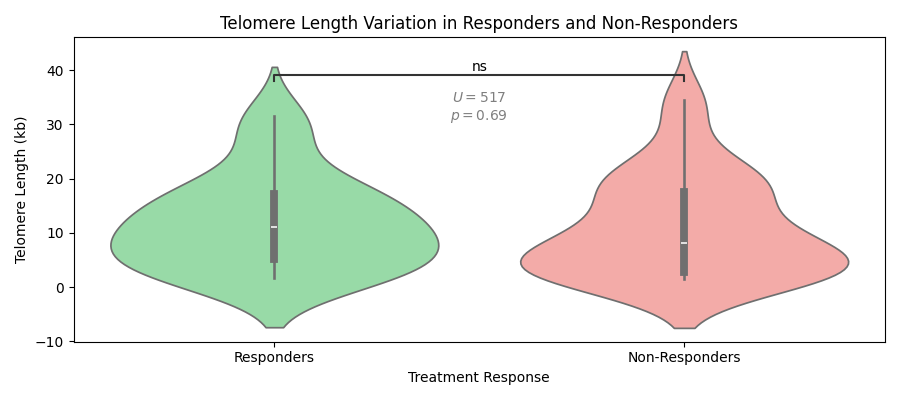

In [16]:
hamd_response_tl_fig, hamd_response_tl_ax = plt.subplots(1, 1, figsize=(9, 4))

hamd_response_tl_ax.set(
    title="Telomere Length Variation in Responders and Non-Responders",
    xlabel="Treatment Response",
    ylabel="Telomere Length (kb)",
)

sns.violinplot(
    x=hamd_response_labels,
    y=data.telomere_length,
    ax=hamd_response_tl_ax,
    hue=hamd_response_labels,
    palette={"Responders": palette[2], "Non-Responders": palette[3]},
)

annotator = Annotator(
    ax=hamd_response_tl_ax,
    pairs=[("Responders", "Non-Responders")],
    x=hamd_response_labels,
    y=data.telomere_length,
)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()

hamd_response_tl_ax.text(
    0.5,
    33,
    f"$U = {hamd_response_tl_comp.statistic:.0f}$"
    f"\n$p = {hamd_response_tl_comp.pvalue:.2f}$",
    alpha=0.5,
    ha="center",
    va="center",
)

hamd_response_tl_fig.tight_layout()
hamd_response_tl_fig.savefig(
    "figures/(HAMD) Telomere Length Variation in Responders and Non-Responders.png",
    dpi=300,
)

<h3>Responder Proportion of Each Treatment Mode</h3>

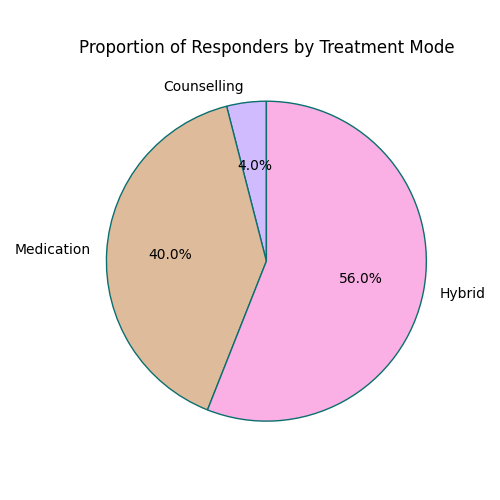

In [17]:
hamd_responders_fig, hamd_responders_ax = plt.subplots(1, 1, figsize=(5, 5))

plt.pie(
    x=hamd_responders.value_counts().sort_index(),
    colors=palette[4:],
    autopct="%1.1f%%",
    labels=mode_names,
    startangle=90,
    wedgeprops={"edgecolor": (0.043, 0.435, 0.435, 1.0), "linewidth": 1},
)

hamd_responders_ax.set(title="Proportion of Responders by Treatment Mode")

hamd_responders_fig.tight_layout()
hamd_responders_fig.savefig(
    "figures/(HAMD) Proportion of Responders by Treatment Mode.png", dpi=300
)

<h3>Response Rate of Each Treatment Mode</h3>

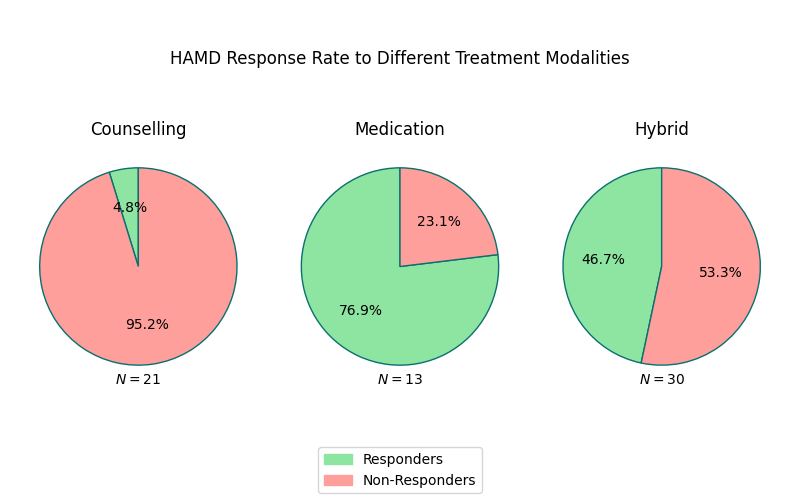

In [18]:
hamd_response_mode_fig, hamd_response_mode_ax = plt.subplots(1, 3, figsize=(8, 5))
hamd_response_mode_ax.flatten()

hamd_response_mode_fig.suptitle(
    "HAMD Response Rate to Different Treatment Modalities", y=0.9
)

for axis, response_data, mode in zip(
    hamd_response_mode_ax, hamd_mode_response, mode_names
):
    response_sum = len(response_data)
    response_rate = response_data.value_counts().sort_index()

    hrm_wedges, hrm_texts, hrm_autotexts = axis.pie(
        response_rate,
        autopct="%1.1f%%",
        colors=palette[2:],
        startangle=90,
        wedgeprops={"edgecolor": (0.043, 0.435, 0.435, 1.0), "linewidth": 1},
    )

    axis.text(0, -1.15, s=f"$N = {response_sum}$", ha="center", va="center")

    axis.set(title=mode)

colors = [w.get_facecolor() for w in hrm_wedges]
labels = ["Responders", "Non-Responders"]
handles = [Patch(color=c, label=str(l)) for c, l in zip(colors, labels)]

hamd_response_mode_fig.legend(handles=handles, loc="lower center")

hamd_response_mode_fig.tight_layout()
hamd_response_mode_fig.savefig(
    "figures/(HAMD) Response Rate By Treatment Mode", dpi=300
)

<h2>PHQ-9</h2>

<h3>Telomere Length Variation in Responders and Non-Responders</h3>

<h4>Test for Normality (Shapiro Wilk Test)</h4>

In [19]:
phq9_response_temp = data[["phq9_response", "telomere_length"]].copy()
phq9_response_temp["phq9_response"] = phq9_response_labels
pg.normality(data=phq9_response_temp, dv="telomere_length", group="phq9_response")

,W,pval,normal
phq9_response,,,
Responders,0.908957,0.002699,False
Non-Responders,0.862519,0.005698,False


<h4>Test for Homoscedasticity (Levene's Test)</h4>

In [20]:
pg.homoscedasticity(
    data=phq9_response_temp,
    dv="telomere_length",
    group="phq9_response",
    method="levene",
)

,W,pval,equal_var
levene,0.452247,0.503768,True


<h4>Group Comparison (Mann-Whitney Test) & Visualization</h4>

In [21]:
phq9_response_tl_comp = stats.mannwhitneyu(
    x=data.loc[data.phq9_response == 1, "telomere_length"],
    y=data.loc[data.phq9_response == 2, "telomere_length"],
)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Responders vs. Non-Responders: Mann-Whitney-Wilcoxon test two-sided, P_val:2.733e-01 U_stat=5.400e+02


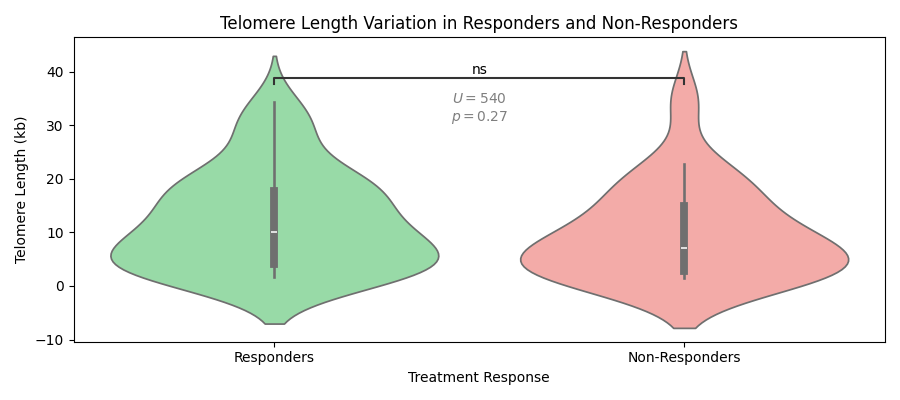

In [22]:
phq9_response_tl_fig, phq9_response_tl_ax = plt.subplots(1, 1, figsize=(9, 4))

phq9_response_tl_ax.set(
    title="Telomere Length Variation in Responders and Non-Responders",
    xlabel="Treatment Response",
    ylabel="Telomere Length (kb)",
)

sns.violinplot(
    x=phq9_response_labels,
    y=data.telomere_length,
    ax=phq9_response_tl_ax,
    hue=phq9_response_labels,
    palette={"Responders": palette[2], "Non-Responders": palette[3]},
)

annotator = Annotator(
    ax=phq9_response_tl_ax,
    pairs=[("Responders", "Non-Responders")],
    x=phq9_response_labels,
    y=data.telomere_length,
)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()

phq9_response_tl_ax.text(
    0.5,
    33,
    f"$U = {phq9_response_tl_comp.statistic:.0f}$"
    f"\n$p = {phq9_response_tl_comp.pvalue:.2f}$",
    alpha=0.5,
    ha="center",
    va="center",
)

phq9_response_tl_fig.tight_layout()
phq9_response_tl_fig.savefig(
    "figures/(PHQ9) Telomere Length Variation in Responders and Non-Responders.png",
    dpi=300,
)

<h3>Response Rate of Each Treatment Mode</h3>

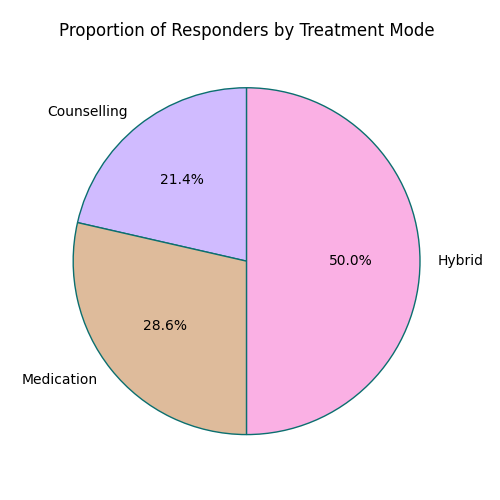

In [23]:
phq9_responders_fig, phq9_responders_ax = plt.subplots(1, 1, figsize=(5, 5))

plt.pie(
    x=phq9_responders.value_counts().sort_index(),
    colors=color_palette[4:],
    autopct="%1.1f%%",
    labels=mode_names,
    startangle=90,
    wedgeprops={"edgecolor": (0.043, 0.435, 0.435, 1.0), "linewidth": 1},
)

phq9_responders_ax.set(title="Proportion of Responders by Treatment Mode")

phq9_responders_fig.tight_layout()
phq9_responders_fig.savefig(
    "figures/(PHQ9) Proportion of Responders by Treatment Mode.png", dpi=300
)

<h1 style="text-align:center">Treatment Reponse Analysis</h1>

<h3>Response Rate of Each Treatment Mode</h3>

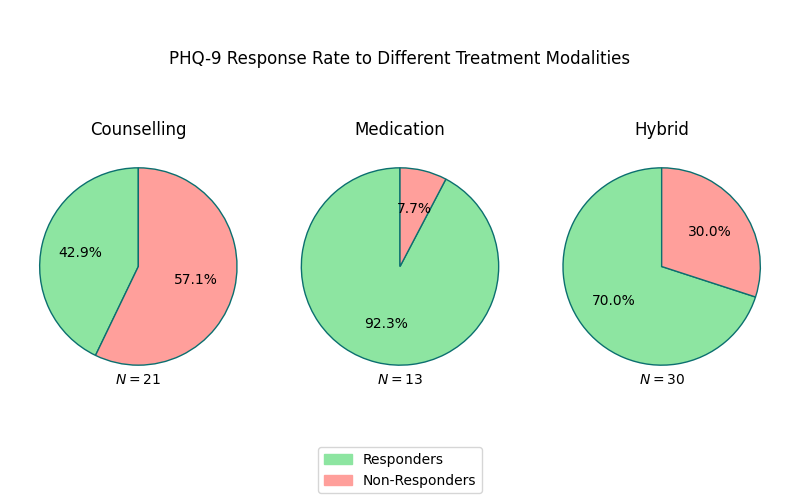

In [24]:
phq9_response_fig, phq9_response_ax = plt.subplots(1, 3, figsize=(8, 5))
phq9_response_ax.flatten()

phq9_response_fig.suptitle(
    "PHQ-9 Response Rate to Different Treatment Modalities", y=0.9
)

for axis, response_data, mode in zip(phq9_response_ax, phq9_mode_response, mode_names):
    response_sum = len(response_data)
    response_rate = response_data.value_counts().sort_index()

    wedges, texts, autotexts = axis.pie(
        response_rate,
        autopct="%1.1f%%",
        colors=palette[2:],
        startangle=90,
        wedgeprops={"edgecolor": (0.043, 0.435, 0.435, 1.0), "linewidth": 1},
    )

    axis.text(0, -1.15, s=f"$N = {response_sum}$", ha="center", va="center")

    axis.set(title=mode)

colors = [w.get_facecolor() for w in wedges]
labels = ["Responders", "Non-Responders"]
handles = [Patch(color=c, label=str(l)) for c, l in zip(colors, labels)]

phq9_response_fig.legend(handles=handles, loc="lower center")

phq9_response_fig.tight_layout()
phq9_response_fig.savefig("figures/(PHQ9) Response Rate By Treatment Mode.png", dpi=300)

<h1 style="text-align:center">Telomere Length Trends</h1>

<h2>Average Sleep Hours</h2>

In [25]:
sleep_tl_linreg = stats.linregress(x=data.average_sleep, y=data.telomere_length)

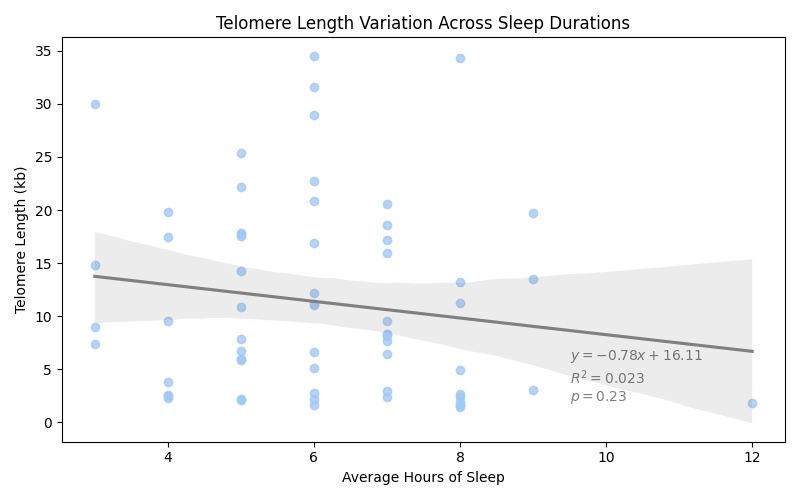

In [ ]:
sleep_tl_fig, sleep_tl_ax = plt.subplots(1, 1, figsize=(8, 5))

sns.regplot(

    data=data,
    x="average_sleep",
    y="telomere_length",
    ax=sleep_tl_ax,

    line_kws=dict(color="gray"),
)

sleep_tl_ax.text(

    x=9.5,
    y=2,
    s=f"$y={sleep_tl_linreg.slope:.2f}x+{sleep_tl_linreg.intercept:.2f}$"
    f"\n$R^{2} = {sleep_tl_linreg.rvalue**2:.3f}$"
    f"\n$p = {sleep_tl_linreg.pvalue:.2f}$",
    alpha=0.5,
)



sleep_tl_ax.set(
    title="Telomere Length Variation Across Sleep Durations",
    xlabel="Average Hours of Sleep",
    ylabel="Telomere Length (kb)",
)


sleep_tl_fig.tight_layout()


sleep_tl_fig.savefig(
    "figures/Telomere Length Variation Across Sleep Durations.png", dpi=300
)

<h2>Body Mass Index (BMI)</h2>

In [59]:
bmi_temp = data[["bmi_asian", "telomere_length"]].copy()
bmi_temp.bmi_asian = data.bmi_asian.map(
    {1: "Underweight", 2: "Normal", 3: "Overweight", 4: "Obese Grade I"}
)

<h3>Test for Normality (Shapiro-Wilk Test)</h3>

In [60]:
pg.normality(data=bmi_temp, dv="telomere_length", group="bmi_asian")

c:\Users\barbie\Desktop\telomere-mental-health\.venv\Lib\site-packages\pingouin\distribution.py:242: UserWarning: Group Underweight has less than 4 valid samples. Returning NaN.
  warnings.warn(f"Group {idx} has less than 4 valid samples. Returning NaN.")


,W,pval,normal
bmi_asian,,,
Normal,0.892720,0.000242,False
Obese Grade I,0.887285,0.370683,True
Overweight,0.904222,0.357317,True
Underweight,NaN,NaN,False


<h3>Test for Normality (Shapiro-Wilk Test)</h3>

In [61]:
pg.homoscedasticity(
    data=bmi_temp, dv="telomere_length", group="bmi_asian", method="levene"
)

,W,pval,equal_var
levene,0.520707,0.669666,True


<h3>Pairwise Comparison (Mann-Whitney) & Visualization</h3>

In [62]:
bmi_pairs = list(
    combinations(["Underweight", "Normal", "Overweight", "Obese Grade I"], r=2)
)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Overweight vs. Underweight: Mann-Whitney-Wilcoxon test two-sided, P_val:6.667e-01 U_stat=9.000e+00
Normal vs. Obese Grade I: Mann-Whitney-Wilcoxon test two-sided, P_val:9.626e-01 U_stat=1.040e+02
Obese Grade I vs. Overweight: Mann-Whitney-Wilcoxon test two-sided, P_val:7.879e-01 U_stat=1.200e+01
Obese Grade I vs. Underweight: Mann-Whitney-Wilcoxon test two-sided, P_val:8.000e-01 U_stat=5.000e+00
Normal vs. Overweight: Mann-Whitney-Wilcoxon test two-sided, P_val:7.436e-01 U_stat=1.640e+02
Normal vs. Underweight: Mann-Whitney-Wilcoxon test two-sided, P_val:9.811e-01 U_stat=5.200e+01


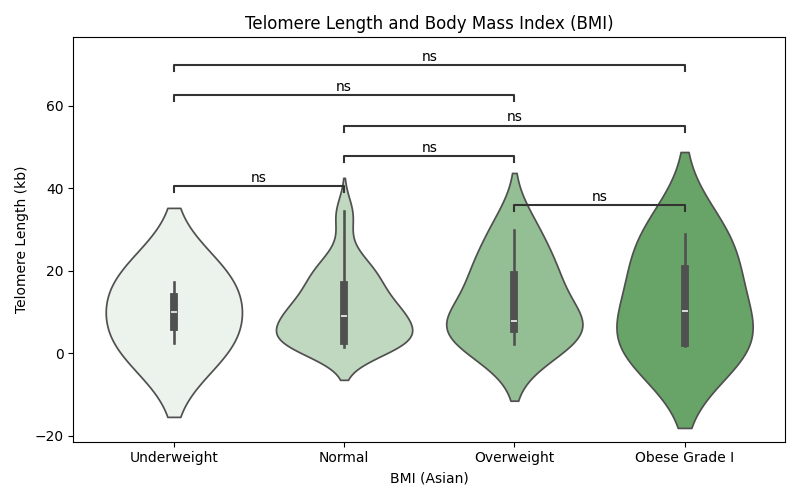

In [81]:
bmi_tl_fig, bmi_tl_ax = plt.subplots(1, 1, figsize=(8, 5))
bmi_palette = sns.light_palette("green", n_colors=6)

sns.violinplot(
    data=bmi_temp,
    x="bmi_asian",
    y="telomere_length",
    hue="bmi_asian",
    ax=bmi_tl_ax,
    order=["Underweight", "Normal", "Overweight", "Obese Grade I"],
    palette=[bmi_palette[i] for i in [1, 3, 2, 0]],
)

annotator = Annotator(
    ax=bmi_tl_ax,
    pairs=bmi_pairs,
    x=bmi_temp.bmi_asian,
    y=bmi_temp.telomere_length,
)

annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()

bmi_tl_ax.set(
    title="Telomere Length and Body Mass Index (BMI)",
    xlabel="BMI (Asian)",
    ylabel="Telomere Length (kb)",
)

bmi_tl_fig.tight_layout()
bmi_tl_fig.savefig("figures/Telomere Length vs. BMI.png", dpi=300)

In [79]:
plt.close("all")

<h2>Adverse Childhood Experiences (ACE Score)</h2>

In [31]:
ace_tl_linreg = stats.linregress(x=data.ace_score, y=data.telomere_length)

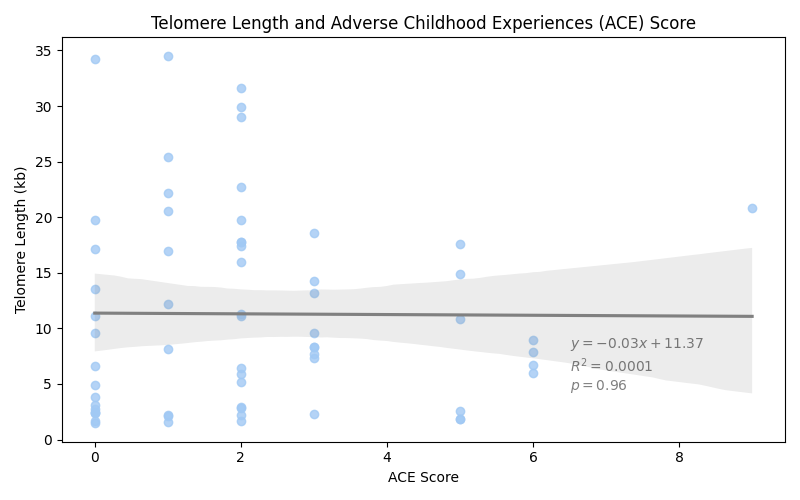

In [32]:
ace_tl_fig, ace_tl_ax = plt.subplots(1, 1, figsize=(8, 5))

sns.regplot(
    data=data,
    x="ace_score",
    y="telomere_length",
    ax=ace_tl_ax,
    line_kws=dict(color="gray"),
)


ace_tl_ax.text(
    x=6.5,
    y=4.5,
    s=f"$y={ace_tl_linreg.slope:.2f}x+{ace_tl_linreg.intercept:.2f}$"
    f"\n$R^{2} = {ace_tl_linreg.rvalue**2:.4f}$"
    f"\n$p = {ace_tl_linreg.pvalue:.2f}$",
    alpha=0.5,
)

ace_tl_ax.set(
    title="Telomere Length and Adverse Childhood Experiences (ACE) Score",
    xlabel="ACE Score",
    ylabel="Telomere Length (kb)",
)

ace_tl_fig.tight_layout()
ace_tl_fig.savefig(
    "figures/Telomere Length and Adverse Childhood Experiences (ACE) Score.png", dpi=300
)

<h2>ACE Score (Pairwise Comparison)</h2>

In [33]:
pairs = list(combinations([0, 1, 2, 3, 5, 6, 9], r=2))

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.799e-01 U_stat=5.900e+01
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=9.000e+01
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:5.203e-01 U_stat=9.400e+01
3 vs. 5: Mann-Whitney-Wilcoxon test two-sided, P_val:6.889e-01 U_stat=3.100e+01
5 vs. 6: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.200e+01
6 vs. 9: Mann-Whitney-Wilcoxon test two-sided, P_val:4.000e-01 U_stat=0.000e+00
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:8.144e-02 U_stat=9.300e+01
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:5.403e-01 U_stat=5.300e+01
2 vs. 5: Mann-Whitney-Wilcoxon test two-sided, P_val:1.365e-01 U_stat=7.700e+01
3 vs. 6: Mann-Whitney-Wilcoxon test two-sided, P_val:2.601e-01 U_stat=2.600e+01
5 vs. 9:

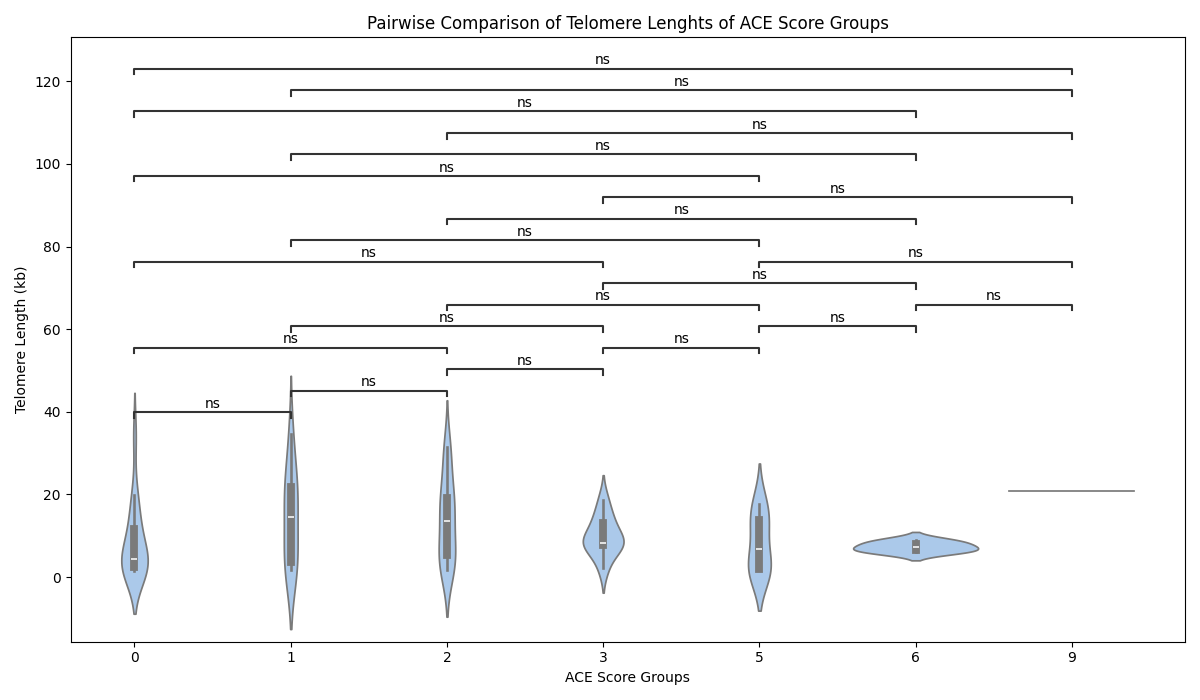

In [34]:
ace_pairwise_fig, ace_pairwise_ax = plt.subplots(1, 1, figsize=(12, 7))

sns.violinplot(x=data.ace_score, y=data.telomere_length, ax=ace_pairwise_ax)

annotator = Annotator(
    ax=ace_pairwise_ax,
    pairs=pairs,
    x=data.ace_score,
    y=data.telomere_length,
)

annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()

ace_pairwise_ax.set(
    title="Pairwise Comparison of Telomere Lenghts of ACE Score Groups",
    xlabel="ACE Score Groups",
    ylabel="Telomere Length (kb)",
)

ace_pairwise_fig.tight_layout()
ace_pairwise_fig.savefig("figures/ACE Score Pairwise Comparison.png", dpi=300)

<h2>ΔHAMD</h2>

In [35]:
delta_hamd = data.hamd_8th_week - data.hamd_initial_score

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

-1 vs. 0: Mann-Whitney-Wilcoxon test two-sided, P_val:5.052e-01 U_stat=7.100e+01
0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:5.333e-01 U_stat=2.000e+00
-2 vs. 0: Mann-Whitney-Wilcoxon test two-sided, P_val:5.055e-01 U_stat=4.700e+01
-3 vs. 0: Mann-Whitney-Wilcoxon test two-sided, P_val:5.697e-01 U_stat=2.000e+01
-4 vs. 0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=4.000e+00


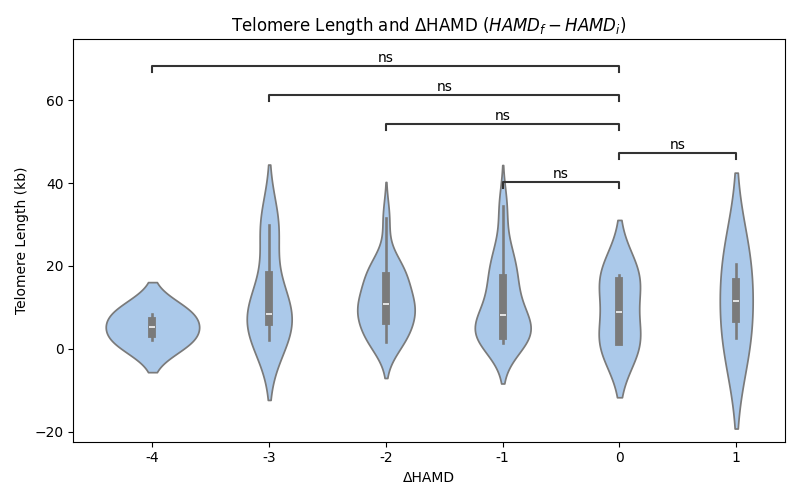

In [36]:
delta_hamd_fig, delta_hamd_ax = plt.subplots(1, 1, figsize=(8, 5))

sns.violinplot(x=delta_hamd, y=data.telomere_length)

delta_hamd_ax.set(
    title="Telomere Length and ΔHAMD $(HAMD_{f} - HAMD_{i}$)",
    xlabel="ΔHAMD",
    ylabel="Telomere Length (kb)",
)

annotator = Annotator(
    ax=delta_hamd_ax,
    pairs=[(0, -4), (0, -3), (0, -2), (0, -1), (0, 1)],
    x=delta_hamd,
    y=data.telomere_length,
)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()


delta_hamd_fig.tight_layout()
delta_hamd_fig.savefig("figures/Telomere Length vs. ΔHAMD.png", dpi=300)

<h2>ΔPHQ-9</h2>

In [37]:
delta_phq9 = data.phq9_8th_week - data.phq9_initial_score

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

-1 vs. 0: Mann-Whitney-Wilcoxon test two-sided, P_val:8.356e-01 U_stat=1.110e+02
0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.300e+01
-2 vs. 0: Mann-Whitney-Wilcoxon test two-sided, P_val:8.571e-01 U_stat=7.700e+01
-3 vs. 0: Mann-Whitney-Wilcoxon test two-sided, P_val:6.065e-01 U_stat=3.700e+01
-4 vs. 0: Mann-Whitney-Wilcoxon test two-sided, P_val:6.000e-01 U_stat=2.000e+00


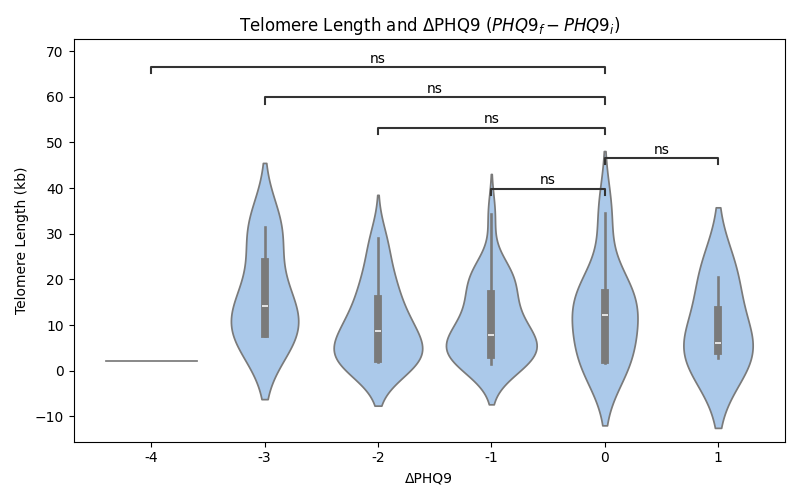

In [38]:
delta_phq9_fig, delta_phq9_ax = plt.subplots(1, 1, figsize=(8, 5))

sns.violinplot(x=delta_phq9, y=data.telomere_length)

delta_phq9_ax.set(
    title="Telomere Length and ΔPHQ9 $(PHQ9_{f} - PHQ9_{i}$)",
    xlabel="ΔPHQ9",
    ylabel="Telomere Length (kb)",
)

annotator = Annotator(
    ax=delta_phq9_ax,
    pairs=[(0, -4), (0, -3), (0, -2), (0, -1), (0, 1)],
    x=delta_phq9,
    y=data.telomere_length,
)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()


delta_phq9_fig.tight_layout()
delta_phq9_fig.savefig("figures/Telomere Length vs. ΔPHQ9.png", dpi=300)